# Dynex SDK - Quantum Transformer Native Gate Circuit Example

### Quantum Self-Attention Transformer

The Quantum Self-Attention Transformer leverages the principles of quantum computing to perform tasks typically handled by classical transformers, particularly in the domain of NLP and LLM. Classical transformers rely heavily on the self-attention mechanism, which allows the model to weigh the importance of different words in a sentence when making predictions or generating new text.

First we import the required packages:

In [7]:
import dynex
from dynex import dynex_circuit
from pennylane import numpy as np
import pennylane as qml

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk            #run it only for the first time please
nltk.download('punkt') #run it only for the first time please
nltk.download('punkt_tab') #run it only for the first time please

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

We define our circuit:

In [9]:
sentences = [
    "Dynex powers Quantum entanglement",
    "Neuromorphic networks process qubits",
    "Dynex solves optimization problems",
    "Entangled qubits process information"
]

tokenization = [word_tokenize(sentence.lower()) for sentence in sentences]
word2vec = Word2Vec(sentences=tokenization, vector_size=8, window=5, min_count=1, workers=4)
qubits = 8
dev = qml.device("default.qubit", wires=qubits)

@qml.qnode(dev)
def QuantumSelfAttention(inputs):
    biIn = [1 if x >= 0 else 0 for x in inputs]
    qml.BasisEmbedding(biIn, wires=range(qubits))
    for layer in range(3):
        for i in range(qubits):
            qml.RX(inputs[i % len(inputs)] * (layer + 1), wires=i)
            qml.RY(inputs[(i + 1) % len(inputs)] * (layer + 1), wires=i)
            qml.RZ(inputs[(i + 2) % len(inputs)] * (layer + 1), wires=i)
        for i in range(qubits - 1):
            qml.CRZ(np.pi / (layer + 2), wires=[i, (i + 1) % qubits])
            qml.CNOT(wires=[i, (i + 1) % qubits])
        for i in range(qubits - 2):
            qml.CRX(inputs[i % len(inputs)], wires=[i, (i + 2) % qubits])
            qml.CRY(inputs[(i + 1) % len(inputs)], wires=[i, (i + 2) % qubits])
            
    qml.QFT(wires=range(qubits))
    qml.adjoint(qml.QFT)(wires=range(qubits))
    qml.GroverOperator(wires=range(qubits))
    for i in range(qubits):
        qml.Hadamard(wires=i)
        qml.T(wires=i)
        qml.RZ(inputs[i % len(inputs)], wires=i)
    qml.BasisEmbedding(biIn, wires=range(qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(qubits)]

dim = [-0.00532336, 0.00226685, 0.05092087, 0.0901195, -0.09305907, -0.07108232, 0.06466064, 0.0802789]

We draw the circuit:

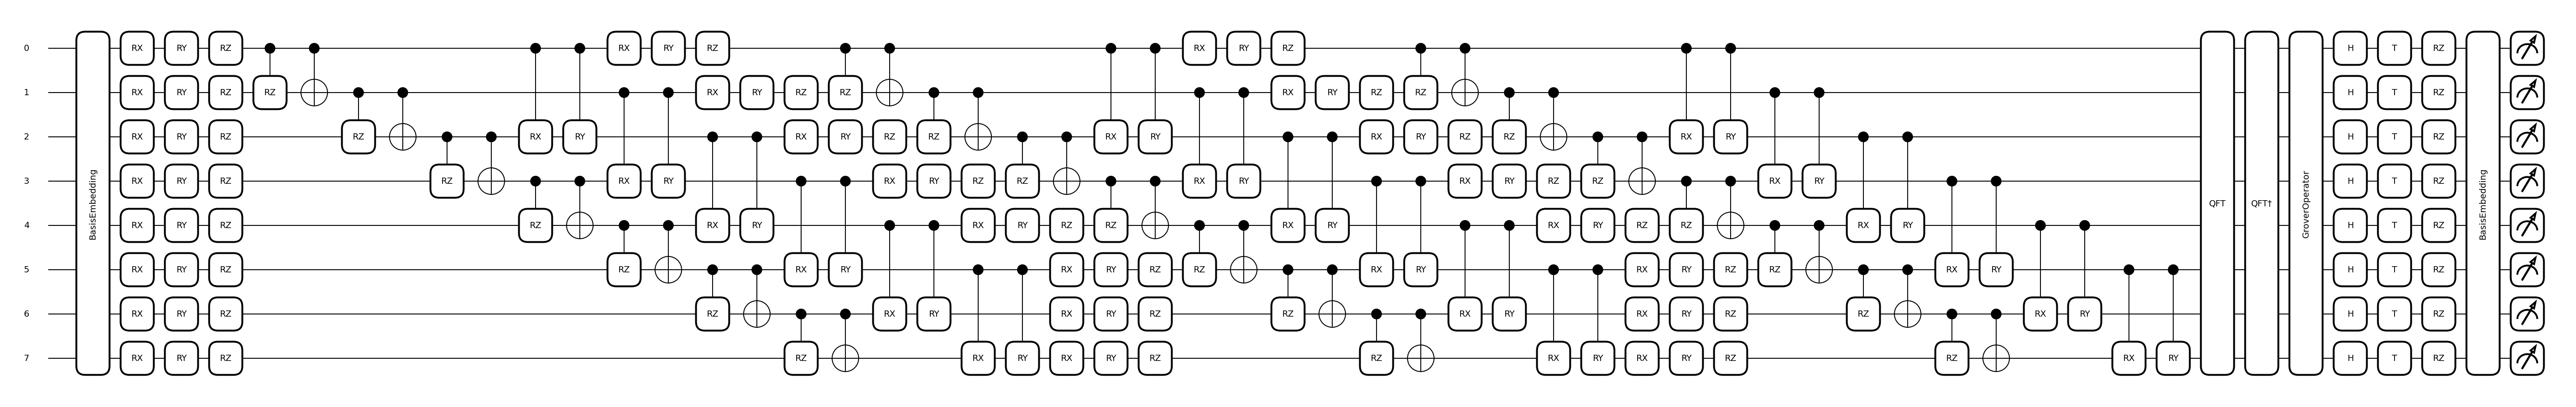

In [10]:
# draw circuit:
_ = qml.draw_mpl(QuantumSelfAttention, style="black_white")(dim)

We execute and measure the circuit on the Dynex platform:

In [11]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def GenerateSentence(input_):
    tokens = word_tokenize(input_.lower())
    iEmbeddings = np.array([word2vec.wv[word] for word in tokens])
    attOutputs = []
    for embedding in iEmbeddings:
        attOUT = dynex_circuit.execute(QuantumSelfAttention, embedding, qubits, method='measure', num_reads=1000, 
                                 integration_steps=100, debugging=False, mainnet=True, is_cluster=True, shots=1)
        softOUT = softmax(attOUT)
        attOutputs.append(softOUT)
    generated = []
    while len(generated) < 4:
        for i, output in enumerate(attOutputs):
            if len(generated) >= 4:
                break
            combVec = 0.5 * iEmbeddings[i] + 0.5 * output
            clWords = word2vec.wv.similar_by_vector(combVec, topn=5)
            tSim = sum(sim for _, sim in clWords)
            randVal = np.random.random() * tSim
            cumulativeSim = 0
            for word, sim in clWords:
                cumulativeSim += sim
                if cumulativeSim > randVal:
                    if word not in generated:
                        generated.append(word)
                    break
    return ' '.join(generated[:4])

input_ = np.random.choice(sentences)
generated = GenerateSentence(input_)

print(f"Generated: {generated}")

╭────────────┬──────────┬─────────────────┬─────────────┬───────────┬────────────────┬────────────┬─────────┬────────────────╮
│   DYNEXJOB │   QUBITS │   QUANTUM GATES │   BLOCK FEE │   ELAPSED │   WORKERS READ │   CIRCUITS │   STEPS │   GROUND STATE │
├────────────┼──────────┼─────────────────┼─────────────┼───────────┼────────────────┼────────────┼─────────┼────────────────┤
│      30238 │      100 │             554 │        0.19 │      0.41 │              1 │       1000 │     100 │      547936.00 │
╰────────────┴──────────┴─────────────────┴─────────────┴───────────┴────────────────┴────────────┴─────────┴────────────────╯
╭────────────┬─────────────────┬────────────┬───────┬──────────┬─────────────┬─────────────────────────────┬───────────┬──────────╮
│     WORKER │         VERSION │   CIRCUITS │   LOC │   ENERGY │     RUNTIME │                 LAST UPDATE │     STEPS │   STATUS │
├────────────┼─────────────────┼────────────┼───────┼──────────┼─────────────┼───────────────────────